In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Example graph
G = nx.Graph()
G.add_edges_from([
    (0,1), (1,2), (1,3), (2,3), (2,4),
    (3,4), (4,5), (5,6), (5,7), (6,7)
])

# Compute core number for each node
core_numbers = nx.core_number(G)
print("Core number of each node:")
for node, k in sorted(core_numbers.items()):
    print(f"  Node {node}: k = {k}")

Core number of each node:
  Node 0: k = 1
  Node 1: k = 2
  Node 2: k = 2
  Node 3: k = 2
  Node 4: k = 2
  Node 5: k = 2
  Node 6: k = 2
  Node 7: k = 2


Maximum k-core: 8-core with 15 nodes
Nodes in the main core (the superspreaders):
['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14']

Recovered 15/15 true superspreaders
Precision: 1.000


C:\Users\user\AppData\Local\Temp\ipykernel_13956\3336879977.py:102: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


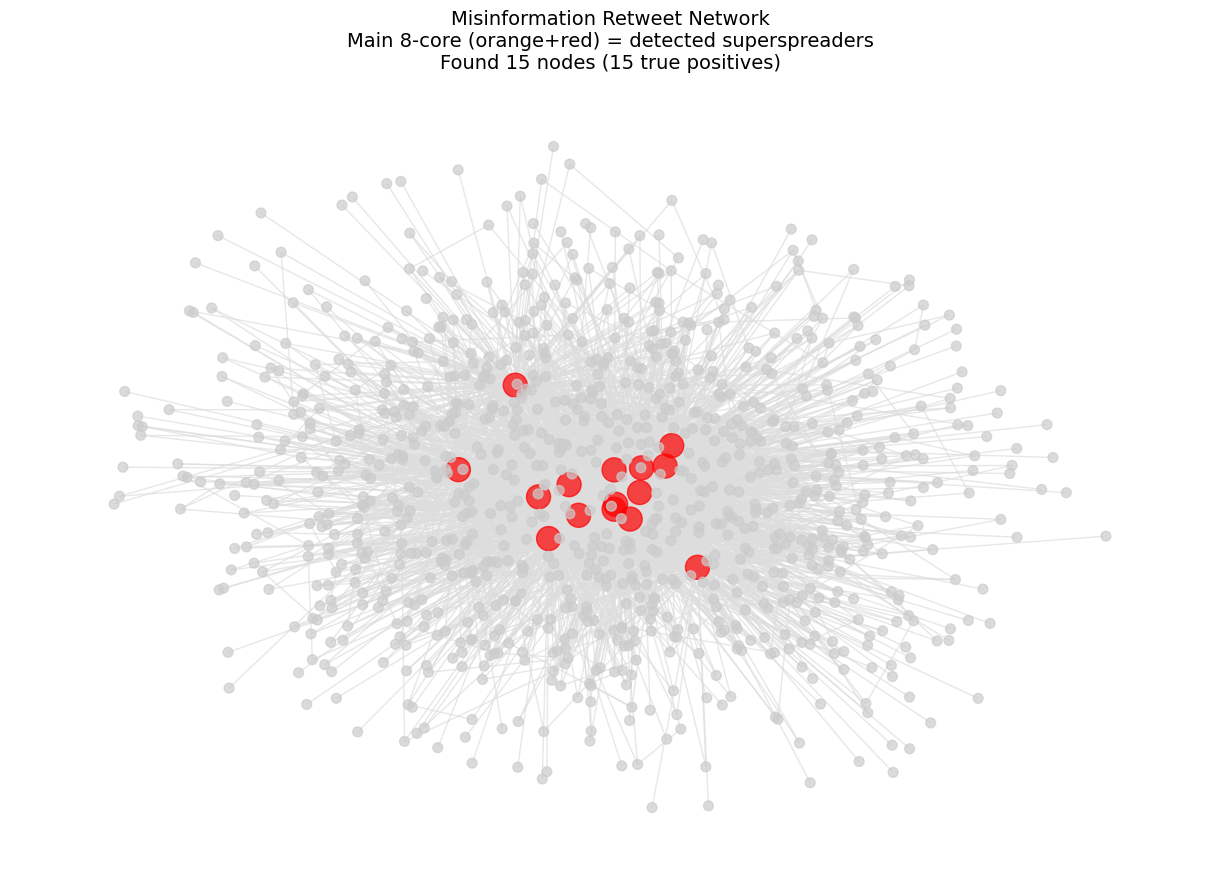

In [9]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

random.seed(42)
np.random.seed(42)

# =============================================
# 1. Build a realistic misinformation retweet graph
# =============================================
G = nx.DiGraph()   # directed: A retweets B → A → B

n_users = 1000

# 15 superspreaders in the dense core
superspreaders = [f"S{i}" for i in range(15)]

# 985 normal users
normal_users = [f"N{i}" for i in range(985)]

all_users = superspreaders + normal_users
G.add_nodes_from(all_users)

# Superspreaders retweet each other heavily (core)
for i in range(len(superspreaders)):
    for j in range(i+1, len(superspreaders)):
        if random.random() < 0.7:       # dense core
            G.add_edge(superspreaders[i], superspreaders[j])
            if random.random() < 0.6:
                G.add_edge(superspreaders[j], superspreaders[i])  # mutual

# Normal users mostly retweet superspreaders (one-hop or two-hop)
for user in normal_users:
    # each normal user retweets 1–5 accounts, mostly superspreaders
    targets = random.sample(superspreaders, k=random.randint(1, 4))
    if random.random() < 0.3:   # 30% also retweet another normal user
        targets += random.sample(normal_users, k=1)
    for t in targets:
        G.add_edge(user, t)

# A few random peripheral retweets
for _ in range(500):
    u = random.choice(normal_users)
    v = random.choice(normal_users)
    if u != v and random.random() < 0.02:
        G.add_edge(u, v)

# =============================================
# 2. k-core decomposition on the UNDIRECTED version
#    (standard practice for superspreader detection)
# =============================================
G_undirected = G.to_undirected()

core_number = nx.core_number(G_undirected)

# Find the main (highest) k-core
max_k = max(core_number.values())
main_core_nodes = [node for node, k in core_number.items() if k == max_k]

print(f"Maximum k-core: {max_k}-core with {len(main_core_nodes)} nodes")
print("Nodes in the main core (the superspreaders):")
print(main_core_nodes)

# How many were our planted superspreaders?
recovered = len(set(main_core_nodes) & set(superspreaders))
print(f"\nRecovered {recovered}/{len(superspreaders)} true superspreaders")
print(f"Precision: {recovered/len(main_core_nodes):.3f}")

# =============================================
# 3. Visualization
# =============================================
plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G_undirected, seed=42, k=0.15)

# Node colors: superspreaders red, main core orange, others light gray
node_colors = []
for node in G_undirected.nodes():
    if node in superspreaders:
        node_colors.append('#ff0000')      # true superspreaders = red
    elif node in main_core_nodes:
        node_colors.append('#ff8800')      # false positives = orange
    else:
        node_colors.append('#cccccc')

# Node sizes: bigger for higher core number
node_sizes = [300 if k >= max_k-1 else 50 for k in core_number.values()]

nx.draw(G_undirected, pos,
        node_color=node_colors,
        node_size=node_sizes,
        edge_color='#dddddd',
        alpha=0.7,
        with_labels=False)

plt.title(f"Misinformation Retweet Network\n"
          f"Main {max_k}-core (orange+red) = detected superspreaders\n"
          f"Found {len(main_core_nodes)} nodes ({recovered} true positives)", 
          fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

Guarantee network: 10 firms, 12 guarantees

Highest k-core: 2
Firms in highest core (most fragile cluster):
  FirmA (credit: 520)
  FirmB (credit: 540)
  FirmC (credit: 500)

 Starting cascade from FirmC (credit: 500)
  → FirmB penalized. New score: 440
 FirmB defaults!
  → FirmA penalized. New score: 420
 FirmA defaults!
  → BigBank penalized. New score: 700

Final defaulted firms: {'FirmC', 'FirmB', 'FirmA'}


C:\Users\user\AppData\Local\Temp\ipykernel_13956\1199653700.py:143: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


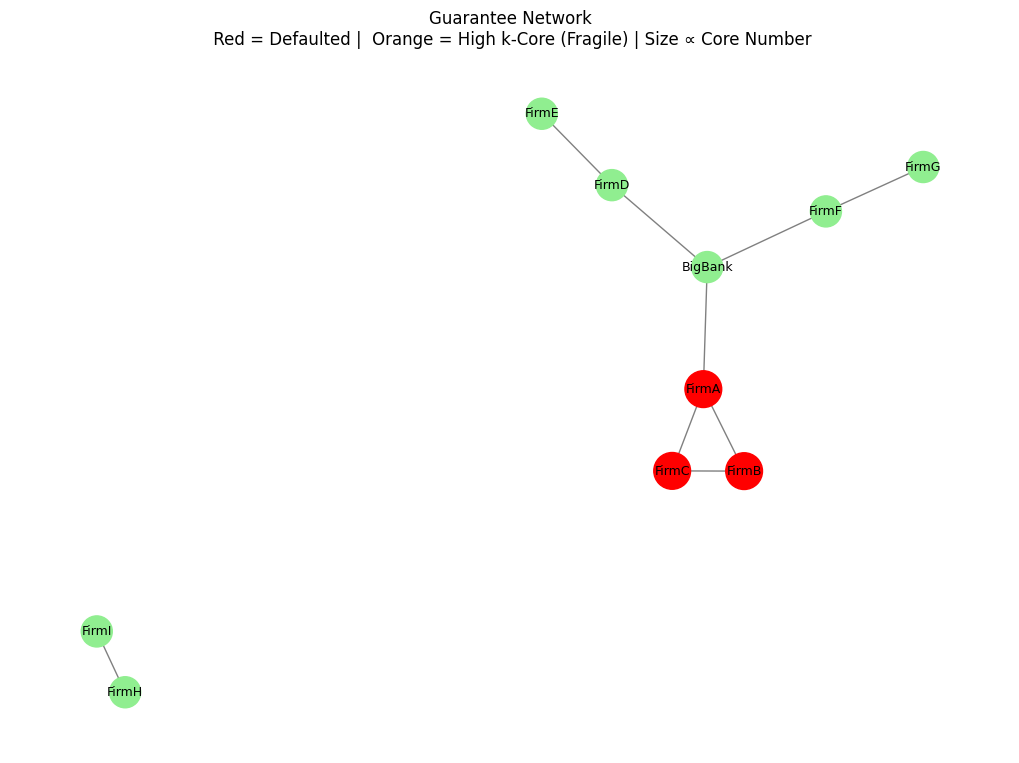


 RISK REPORT
• Highest risk cluster (k=2): ['FirmA', 'FirmB', 'FirmC']
• Cascade started from: FirmC
• Total firms defaulted: 3
• Systemically important guarantor affected: False


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# ----------------------------
# 1. Simulate Corporate Guarantee Network
# ----------------------------
# Nodes: Companies
# Edges: A → B means "A guarantees B's debt"
# (If B defaults, A must pay → A's financial health deteriorates)

guarantees = [
    # Core fragile cluster: tightly inter-guaranteed SMEs
    ("FirmA", "FirmB"),
    ("FirmB", "FirmC"),
    ("FirmC", "FirmA"),
    ("FirmA", "FirmC"),
    ("FirmB", "FirmA"),
    
    # Another cluster (less dense)
    ("FirmD", "FirmE"),
    ("FirmE", "FirmD"),
    
    # Peripheral firms (single guarantees)
    ("FirmF", "FirmG"),
    ("FirmH", "FirmI"),
    
    # Systemically important firm: guarantees multiple clusters
    ("BigBank", "FirmA"),
    ("BigBank", "FirmD"),
    ("BigBank", "FirmF"),
]

G = nx.DiGraph()
G.add_edges_from(guarantees)

# Assign credit scores (lower = riskier; 300–850 scale)
credit_scores = {
    "FirmA": 520, "FirmB": 540, "FirmC": 500,
    "FirmD": 600, "FirmE": 620,
    "FirmF": 580, "FirmG": 650,
    "FirmH": 700, "FirmI": 720,
    "BigBank": 800
}
nx.set_node_attributes(G, credit_scores, "credit_score")

# Convert to undirected for k-core (guarantee risk is mutual in effect)
G_undir = G.to_undirected()

print(f"Guarantee network: {G.number_of_nodes()} firms, {G.number_of_edges()} guarantees")

# ----------------------------
# 2. Find Fragile Clusters via k-Core Decomposition
# ----------------------------
# k-core: maximal subgraph where every node has degree >= k
k_cores = nx.core_number(G_undir)

# Find the highest k-core (most tightly interlinked)
max_k = max(k_cores.values())
print(f"\nHighest k-core: {max_k}")
print("Firms in highest core (most fragile cluster):")
core_firms = [node for node, k in k_cores.items() if k == max_k]
for firm in core_firms:
    print(f"  {firm} (credit: {credit_scores[firm]})")

# ----------------------------
# 3. Simulate Default Cascade in High-Risk Core
# ----------------------------
def simulate_guarantee_cascade(graph, initial_default, credit_dict, threshold=600):
    """
    Simulate cascade: if a firm defaults (credit < threshold), 
    its guarantors lose credit score points.
    If their score drops below threshold, they default too.
    """
    defaulted = set()
    queue = [initial_default]
    defaulted.add(initial_default)
    
    # Copy scores to avoid mutation
    current_scores = credit_dict.copy()
    
    print(f"\n Starting cascade from {initial_default} (credit: {current_scores[initial_default]})")
    
    while queue:
        failed_firm = queue.pop(0)
        # Find all firms that guaranteed this firm (in-directed edges)
        guarantors = list(graph.predecessors(failed_firm))
        
        for guarantor in guarantors:
            if guarantor in defaulted:
                continue
            # Penalty: lose 100 credit points for each defaulted guarantee
            current_scores[guarantor] -= 100
            print(f"  → {guarantor} penalized. New score: {current_scores[guarantor]}")
            
            if current_scores[guarantor] < threshold and guarantor not in defaulted:
                defaulted.add(guarantor)
                queue.append(guarantor)
                print(f" {guarantor} defaults!")
    
    return defaulted, current_scores

# Trigger default of weakest firm in core
initial_default = min(core_firms, key=lambda x: credit_scores[x])
final_defaulted, final_scores = simulate_guarantee_cascade(G, initial_default, credit_scores, threshold=600)

print(f"\nFinal defaulted firms: {final_defaulted}")

# ----------------------------
# 4. Visualize: Color by k-core and default status
# ----------------------------
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_undir, seed=42)

# Node colors: 
# - Red: defaulted
# - Orange: in high k-core but survived
# - Lightgreen: low-risk
node_colors = []
node_sizes = []

for node in G_undir.nodes():
    size = 300 + 200 * k_cores[node]  # bigger = higher core
    node_sizes.append(size)
    
    if node in final_defaulted:
        node_colors.append("red")
    elif k_cores[node] == max_k:
        node_colors.append("orange")
    else:
        node_colors.append("lightgreen")

nx.draw(
    G_undir, pos,
    node_color=node_colors,
    node_size=node_sizes,
    with_labels=True,
    font_size=9,
    edge_color="gray"
)

plt.title("Guarantee Network\n Red = Defaulted |  Orange = High k-Core (Fragile) | Size ∝ Core Number")
plt.tight_layout()
plt.show()

# ----------------------------
# 5. Risk Report
# ----------------------------
print("\n RISK REPORT")
print(f"• Highest risk cluster (k={max_k}): {core_firms}")
print(f"• Cascade started from: {initial_default}")
print(f"• Total firms defaulted: {len(final_defaulted)}")
print(f"• Systemically important guarantor affected: {'BigBank' in final_defaulted}")

Network: 500 nodes, 591 edges
Highest k-core: 4
Top k-core seeds: [148, 147, 57, 291, 289]
Top degree seeds: [148, 147, 57, 291, 289]

Average spread after 20 trials:
  From top k-core seeds: 28.8
  From top degree seeds: 29.3


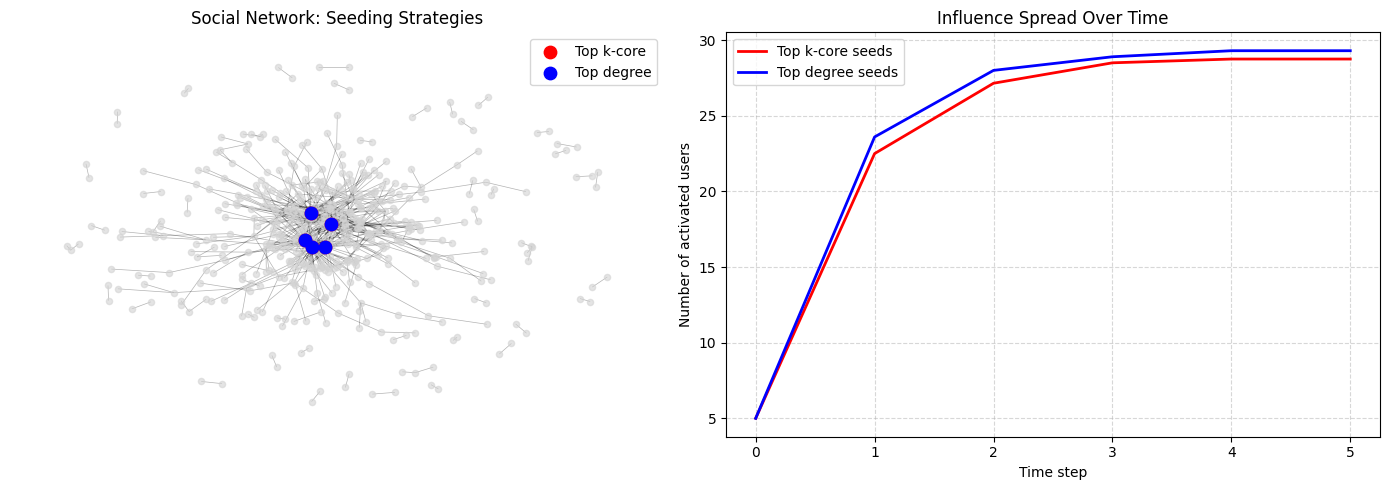

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# -------------------------------
# 1. Generate a synthetic social network
# -------------------------------
# Use a power-law degree sequence to mimic real social networks
n = 500
degrees = nx.utils.powerlaw_sequence(n, exponent=2.5)
degrees = [max(int(d), 1) for d in degrees]
# Adjust to make sum even (required for configuration model)
if sum(degrees) % 2 == 1:
    degrees[0] += 1

G = nx.configuration_model(degrees, create_using=nx.Graph())
G = nx.Graph(G)  # Remove parallel edges & self-loops
G.remove_edges_from(nx.selfloop_edges(G))

print(f"Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# -------------------------------
# 2. Compute k-core decomposition
# -------------------------------
core_numbers = nx.core_number(G)
# Get nodes in the highest k-core
max_k = max(core_numbers.values())
k_core_nodes = [node for node, k in core_numbers.items() if k == max_k]

# Top 5 nodes by core number (fallback: by degree if tie)
sorted_by_core = sorted(core_numbers.items(), key=lambda x: (-x[1], -G.degree(x[0])))
top_kcore_seeds = [node for node, _ in sorted_by_core[:5]]

# Top 5 by degree
degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)
top_degree_seeds = [node for node, _ in degree_sorted[:5]]

print(f"Highest k-core: {max_k}")
print(f"Top k-core seeds: {top_kcore_seeds}")
print(f"Top degree seeds: {top_degree_seeds}")

# -------------------------------
# 3. Simple Independent Cascade Model (ICM)
# -------------------------------
def independent_cascade(G, seeds, p=0.1, max_iter=10):
    """
    Simulate influence spread using Independent Cascade Model.
    Each activated node gets one chance to activate each neighbor with prob p.
    """
    activated = set(seeds)
    newly_activated = set(seeds)
    steps = [len(activated)]

    for _ in range(max_iter):
        if not newly_activated:
            break
        next_activated = set()
        for node in newly_activated:
            for neighbor in G.neighbors(node):
                if neighbor not in activated:
                    if random.random() < p:
                        next_activated.add(neighbor)
        newly_activated = next_activated
        activated.update(newly_activated)
        steps.append(len(activated))
    return activated, steps

# Run multiple simulations for robustness
def simulate_diffusion(G, seeds, p=0.1, trials=20):
    total = 0
    histories = []
    for _ in range(trials):
        final_set, steps = independent_cascade(G, seeds, p=p)
        total += len(final_set)
        histories.append(steps)
    avg_final = total / trials
    # Pad histories to same length for averaging
    max_len = max(len(h) for h in histories)
    for h in histories:
        while len(h) < max_len:
            h.append(h[-1])
    avg_history = np.mean(np.array(histories), axis=0)
    return avg_final, avg_history

# Simulate both strategies
random.seed(42)
np.random.seed(42)

final_kcore, history_kcore = simulate_diffusion(G, top_kcore_seeds, p=0.1)
final_degree, history_degree = simulate_diffusion(G, top_degree_seeds, p=0.1)

print(f"\nAverage spread after 20 trials:")
print(f"  From top k-core seeds: {final_kcore:.1f}")
print(f"  From top degree seeds: {final_degree:.1f}")

# -------------------------------
# 4. Visualization
# -------------------------------
plt.figure(figsize=(14, 5))

# Subplot 1: Network with k-core highlighted
plt.subplot(1, 2, 1)
pos = nx.spring_layout(G, seed=42, k=0.15, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='lightgray', alpha=0.6)
# Highlight top k-core seeds
nx.draw_networkx_nodes(G, pos, nodelist=top_kcore_seeds, node_color='red', node_size=80, label='Top k-core')
# Highlight top degree seeds
nx.draw_networkx_nodes(G, pos, nodelist=top_degree_seeds, node_color='blue', node_size=80, label='Top degree')
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)
plt.title("Social Network: Seeding Strategies")
plt.legend()
plt.axis('off')

# Subplot 2: Diffusion over time
plt.subplot(1, 2, 2)
steps = list(range(len(history_kcore)))
plt.plot(steps, history_kcore, label='Top k-core seeds', color='red', linewidth=2)
plt.plot(steps, history_degree, label='Top degree seeds', color='blue', linewidth=2)
plt.xlabel("Time step")
plt.ylabel("Number of activated users")
plt.title("Influence Spread Over Time")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Network built: 200 users, 714 interactions

Louvain found 3 communities.
Modularity: 0.488

 Community Analysis (with Conductance & Homogeneity):
  Community 0: 100 pro-vax, 0 skeptical | Conductance=0.011 | Homogeneity=100.00%
  Community 1: 0 pro-vax, 99 skeptical | Conductance=0.012 | Homogeneity=100.00%
  Community 2: 0 pro-vax, 1 skeptical | Conductance=1.000 | Homogeneity=100.00%

 Network homophily (ideological alignment): 98.88%


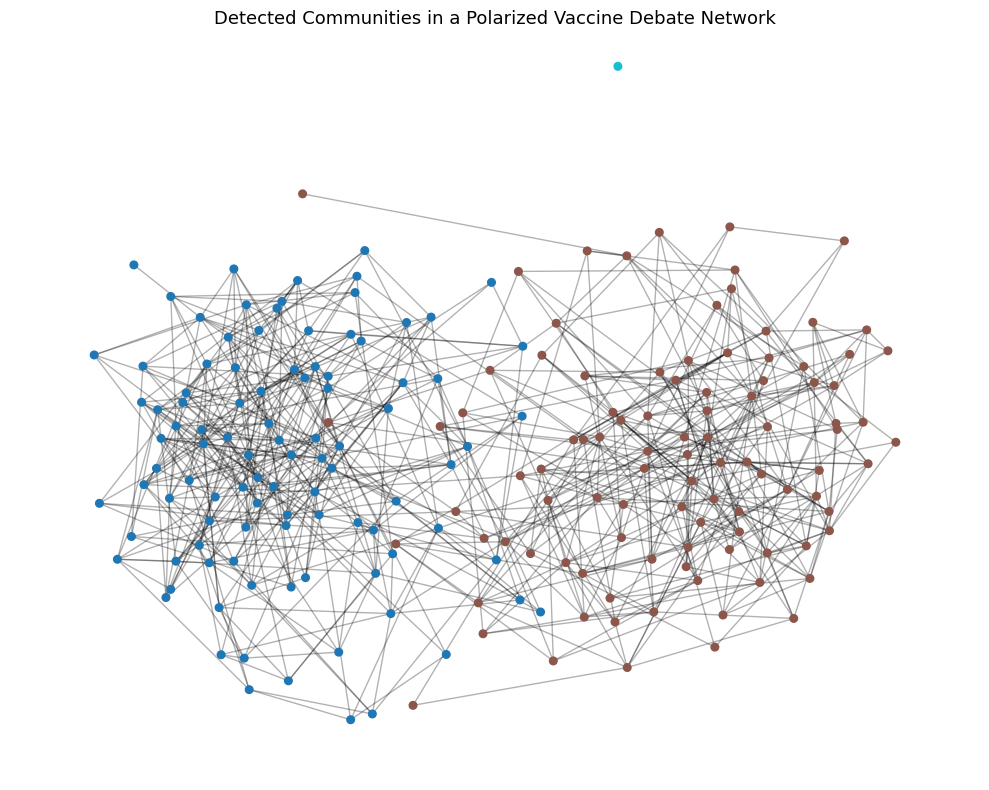


  Potential misinformation hub: User 129
    → In skeptical-dominant community (size=99)
    → Degree: 12, Community conductance: 0.012
    → Low conductance suggests this cluster is an insulated echo chamber.


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# 1. Build a polarized network: two echo chambers + a few bridge users
G = nx.Graph()
G.add_nodes_from(range(200))  # 0–99: Pro-Vax, 100–199: Skeptical

random.seed(42)
# Dense internal connections
for i in range(100):
    for j in range(i+1, 100):
        if random.random() < 0.08:
            G.add_edge(i, j)

for i in range(100, 200):
    for j in range(i+1, 200):
        if random.random() < 0.07:
            G.add_edge(i, j)

# Add bridge edges
for _ in range(8):
    a = random.randint(0, 99)
    b = random.randint(100, 199)
    G.add_edge(a, b)

print(f"Network built: {G.number_of_nodes()} users, {G.number_of_edges()} interactions")

# Ground-truth labels (for homophily)
true_label = {node: 0 if node < 100 else 1 for node in G.nodes()}  # 0=Pro, 1=Skeptical

# 2. Detect communities
communities = nx.community.louvain_communities(G, seed=42)
modularity = nx.community.modularity(G, communities)
print(f"\nLouvain found {len(communities)} communities.")
print(f"Modularity: {modularity:.3f}")


def conductance(G, community):
    """Fraction of edges leaving the community vs. total edges incident to it."""
    comm_set = set(community)
    cut_edges = 0
    total_edges = 0
    for node in community:
        for neighbor in G.neighbors(node):
            total_edges += 1
            if neighbor not in comm_set:
                cut_edges += 1
    return cut_edges / total_edges if total_edges > 0 else 1.0

def homophily(G, label_dict):
    """Fraction of edges connecting nodes with the same label."""
    same = 0
    total = G.number_of_edges()
    for u, v in G.edges():
        if label_dict[u] == label_dict[v]:
            same += 1
    return same / total if total > 0 else 1.0

# 3. Analyze communities with conductance and homogeneity
print("\n Community Analysis (with Conductance & Homogeneity):")
for i, comm in enumerate(communities):
    pro = sum(1 for node in comm if node < 100)
    skept = len(comm) - pro
    size = len(comm)
    
    # Conductance
    cond = conductance(G, comm)
    
    # Homogeneity: % of dominant group in this community
    dominant_frac = max(pro, skept) / size
    
    print(f"  Community {i}: {pro} pro-vax, {skept} skeptical "
          f"| Conductance={cond:.3f} | Homogeneity={dominant_frac:.2%}")

# Network-wide homophily
net_homophily = homophily(G, true_label)
print(f"\n Network homophily (ideological alignment): {net_homophily:.2%}")

# 4. Visualize
partition = {}
for i, comm in enumerate(communities):
    for node in comm:
        partition[node] = i

colors = [partition[node] for node in G.nodes()]
pos = nx.spring_layout(G, seed=42, k=0.4)

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.tab10, node_size=30)
nx.draw_networkx_edges(G, pos, alpha=0.3)
plt.title("Detected Communities in a Polarized Vaccine Debate Network", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

# 5. Find misinformation hub in skeptical-dominant community
skeptical_community = None
for comm in communities:
    skept_count = sum(1 for node in comm if node >= 100)
    if skept_count > len(comm) * 0.8:
        skeptical_community = comm
        break

if skeptical_community:
    sub = G.subgraph(skeptical_community)
    degrees = dict(sub.degree())
    hub = max(degrees, key=degrees.get)
    hub_cond = conductance(G, skeptical_community)
    print(f"\n  Potential misinformation hub: User {hub}")
    print(f"    → In skeptical-dominant community (size={len(skeptical_community)})")
    print(f"    → Degree: {degrees[hub]}, Community conductance: {hub_cond:.3f}")
    print("    → Low conductance suggests this cluster is an insulated echo chamber.")


Detected 132 merchant communities.

 Network baselines:
  Avg. community density: 0.681
  Avg. community size: 2.0 (σ=2.4)

 Fraud Risk Screening with Anomaly Scores:
  Community 0: size=1, density=0.00, conductance=1.00
    → Anomaly score: 0.03 | 🟢 Normal
  Community 1: size=3, density=0.67, conductance=0.00
    → Anomaly score: 0.30 | 🟢 Normal
  Community 2: size=1, density=0.00, conductance=1.00
    → Anomaly score: 0.03 | 🟢 Normal
  Community 3: size=5, density=0.40, conductance=0.00
    → Anomaly score: 0.30 | 🟢 Normal
  Community 4: size=1, density=0.00, conductance=1.00
    → Anomaly score: 0.03 | 🟢 Normal
  Community 5: size=2, density=1.00, conductance=0.00
    → Anomaly score: 0.80 | 🟢 Normal
  Community 6: size=5, density=0.40, conductance=0.00
    → Anomaly score: 0.30 | 🟢 Normal
  Community 7: size=2, density=1.00, conductance=0.00
    → Anomaly score: 0.80 | 🟢 Normal
  Community 8: size=2, density=1.00, conductance=0.00
    → Anomaly score: 0.80 | 🟢 Normal
  Community 9

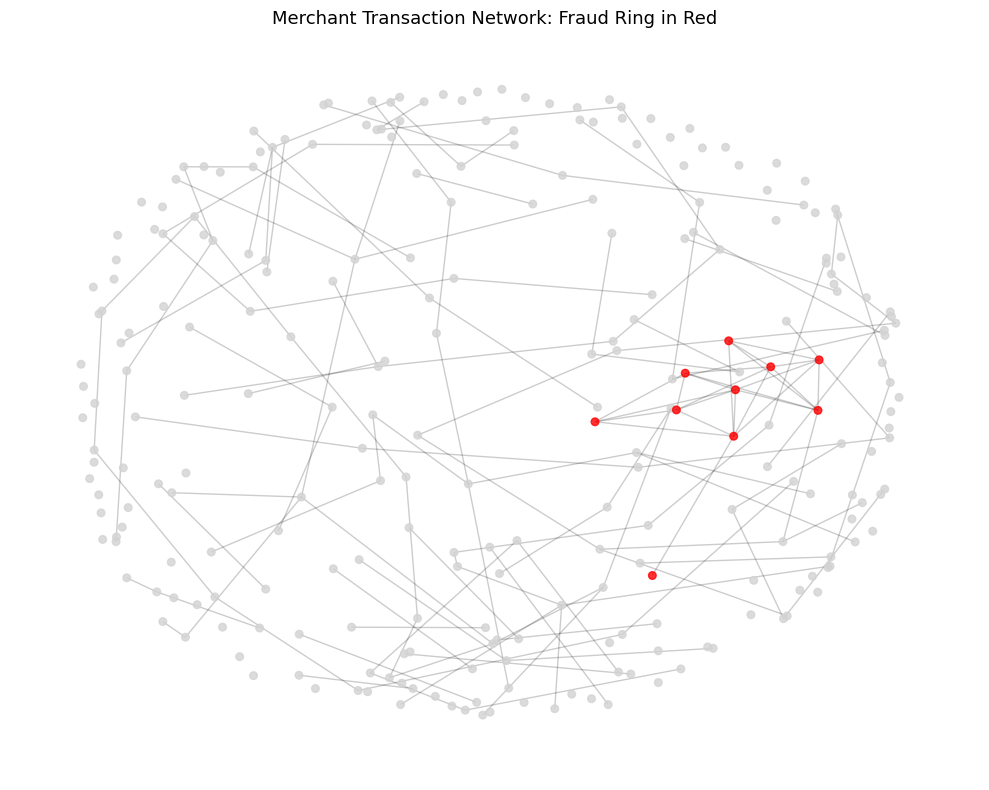


 ALERT: 1 high-risk community(ies) detected.
Recommendation: Freeze onboarding, investigate shared attributes (IP, bank, device).


In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np 
# -------------------------------
# 1. Build a transaction network: legitimate + one fraud ring
# -------------------------------
G = nx.Graph()

# Add 250 legitimate merchants (nodes 0–249)
G.add_nodes_from(range(250))

random.seed(101)
# Legit: sparse random links
for _ in range(120):
    a, b = random.sample(range(250), 2)
    G.add_edge(a, b)

# Add fraud ring: 9 fake merchants (nodes 250–258)
# Adds 9 new nodes (250 to 258) to represent a fraud ring—a group of colluding fake merchants.
fraud_nodes = list(range(250, 259))
G.add_nodes_from(fraud_nodes)

# Dense internal links (simulating fake transaction loops)
# Create dense internal connections within the fraud ring
for i in fraud_nodes:
    for j in fraud_nodes:
        if i < j and random.random() < 0.75:
            G.add_edge(i, j)

# Add 2 bridge edges to appear realistic
# Adds 2 edges connecting a fraud node to a legitimate merchant
for _ in range(2):
    a = random.choice(fraud_nodes)  # Fixed typo: was 'fraud_raises'
    b = random.randint(0, 249)
    G.add_edge(a, b)
    
# -------------------------------
# 2. Detect communities
# -------------------------------
communities = nx.community.louvain_communities(G, seed=42)
print(f"\nDetected {len(communities)} merchant communities.") 


# -------------------------------
# 3. Compute global baselines for anomaly scoring
# -------------------------------
# Global average density of all communities
#  Establish reference values for "normal" community behavior in the network
all_densities = []
for comm in communities:
    if len(comm) > 1:
        all_densities.append(nx.density(G.subgraph(comm)))
avg_density = np.mean(all_densities) if all_densities else 0.05

# Global size stats
sizes = [len(comm) for comm in communities]
avg_size = np.mean(sizes)
size_std = np.std(sizes)

print(f"\n Network baselines:")
print(f"  Avg. community density: {avg_density:.3f}")
print(f"  Avg. community size: {avg_size:.1f} (σ={size_std:.1f})")

# -------------------------------
# 4. Flag & score suspicious communities
# -------------------------------
def conductance(G, community):
    comm_set = set(community)
    cut_edges = 0
    total_edges = 0
    for node in community:
        for nbr in G.neighbors(node):
            total_edges += 1
            if nbr not in comm_set:
                cut_edges += 1
    return cut_edges / total_edges if total_edges > 0 else 1.0

print("\n Fraud Risk Screening with Anomaly Scores:")
suspicious_communities = []

# Analyze Each Community
# Compute core metrics:
#   size: number of nodes.
#   density: internal connectivity (0 = no edges, 1 = fully connected).
#   cond: conductance (isolation score).
#   fraud_overlap: how many known fraud nodes (250–258) it contains (for validation only).
for i, comm in enumerate(communities):
    size = len(comm)
    if size <= 1:
        density = 0.0
        cond = 1.0
    else:
        sub = G.subgraph(comm)
        density = nx.density(sub) 
        cond = conductance(G, comm) 
        
    
    # Count known fraud nodes (for demo only)
    # how many known fraud nodes (250–258) it contains
    fraud_overlap = len([n for n in comm if 250 <= n <= 258])
    
    # --- Anomaly Score Components ---
    # 1. Density deviation (higher = more anomalous)
    # # Scaled to [0,1]: 0 = normal density, 1 = fully dense.
    density_score = max(0, density - avg_density) / (1 - avg_density) if avg_density < 1 else 0
    
    # 2. Isolation (low conductance = more suspicious)
    # # Score = 1 when cond = 0 (completely isolated), 0 when cond ≥ 0.5.
    isolation_score = max(0, 0.5 - cond) / 0.5  # scale: 0 (leaky) → 1 (isolated)
    
    # 3. Size deviation (small rings are suspicious)
    # Measures how many standard deviations smaller the community is than average
    size_z = (avg_size - size) / (size_std + 1e-6)  # how much smaller than average?
    size_score = min(1.0, max(0, size_z / 3))  # cap at 3σ
    
    # Combine into overall anomaly score (weighted)
# Emphasizes density most (fraud rings are abnormally dense), then isolation, then small size
    anomaly_score = 0.5 * density_score + 0.3 * isolation_score + 0.2 * size_score
    
    # Heuristic flag
    # Apply a heuristic rule to flag suspicious communities
    is_suspicious = (5 <= size <= 15) and (density > 0.4) and (cond < 0.3)
    if is_suspicious:
        suspicious_communities.append(i)
        risk_tag = "🔴 SUSPICIOUS"
    else:
        risk_tag = "🟢 Normal"
    
    print(f"  Community {i}: size={size}, density={density:.2f}, conductance={cond:.2f}")
    print(f"    → Anomaly score: {anomaly_score:.2f} | {risk_tag}")
    if fraud_overlap > 0:
        print(f"    (Contains {fraud_overlap} known fraud nodes)")

# -------------------------------
# 5. Visualize
# -------------------------------
node_colors = []
for node in G.nodes():
    in_suspicious = False
    for comm_id in suspicious_communities:
        if node in communities[comm_id]:
            node_colors.append('red')
            in_suspicious = True
            break
    if not in_suspicious:
        node_colors.append('lightgray')

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.4)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Merchant Transaction Network: Fraud Ring in Red", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

# Final alert
if suspicious_communities:
    print(f"\n ALERT: {len(suspicious_communities)} high-risk community(ies) detected.")
    print("Recommendation: Freeze onboarding, investigate shared attributes (IP, bank, device).")
else:
    print("\n No suspicious merchant clusters found.")        

Engagement network: 390 users, 2648 interactions

Louvain detected 4 communities.

 Marketing Performance by Community:

Community 0 → Urban Runners (size=100)
  Conversion: 78.0% (tailored) vs 32.0% (generic) → Lift: 144%
 Cohort retention (3 periods): 92.0%
 Avg. engagement similarity (Jaccard): 0.034

Community 1 → Eco-Moms (size=123)
  Conversion: 73.2% (tailored) vs 30.1% (generic) → Lift: 143%
 Cohort retention (3 periods): 80.5%
 Avg. engagement similarity (Jaccard): 0.035

Community 2 → Streetwear Collectors (size=78)
  Conversion: 80.8% (tailored) vs 24.4% (generic) → Lift: 232%
 Cohort retention (3 periods): 98.7%
 Avg. engagement similarity (Jaccard): 0.032

Community 3 → Zero-Waste Advocates (size=89)
  Conversion: 74.2% (tailored) vs 25.8% (generic) → Lift: 187%
 Cohort retention (3 periods): 92.1%
 Avg. engagement similarity (Jaccard): 0.031

 Network-wide Averages:
  Avg. conversion lift from tailored messaging: 176%
  Avg. cohort retention: 90.8%
  Avg. engagement simil

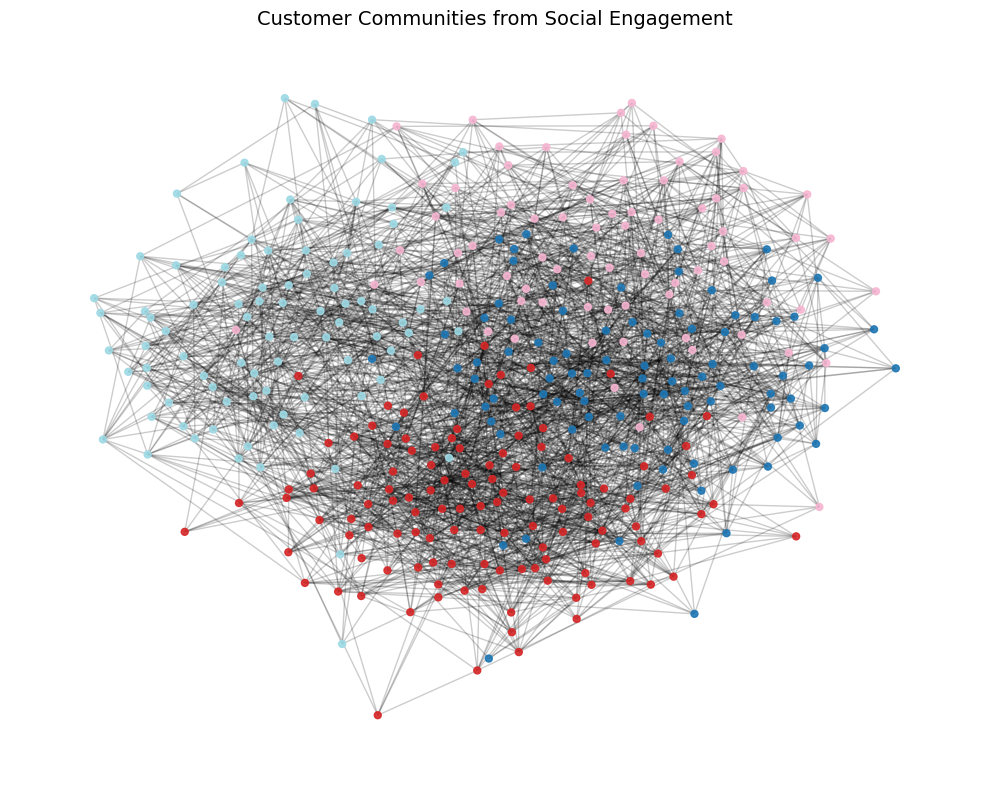

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

random.seed(2025)
np.random.seed(2025)

# -------------------------------
# 1. Simulate a social engagement network with 4 marketing-relevant communities
# -------------------------------
labels = ["Eco-Moms", "Runners", "Streetwear", "Zero-Waste"]
sizes = [120, 100, 80, 90]
intra_prob = 0.09
inter_prob = 0.015

prob_matrix = [[intra_prob if i == j else inter_prob for j in range(len(sizes))] for i in range(len(sizes))]
G = nx.stochastic_block_model(sizes, prob_matrix, seed=2025)

# Ground-truth personas (for simulating behavior)
true_persona = {}
start = 0
for i, size in enumerate(sizes):
    for j in range(start, start + size):
        true_persona[j] = labels[i]
    start += size

print(f"Engagement network: {G.number_of_nodes()} users, {G.number_of_edges()} interactions")

# -------------------------------
# 2. Detect communities
# -------------------------------
detected_comms = nx.community.louvain_communities(G, seed=42)
print(f"\nLouvain detected {len(detected_comms)} communities.")

# -------------------------------
# 3. Simulate marketing outcomes
# -------------------------------

# Define tailored messages and their "relevance score" per true persona
message_effectiveness = {
    "Eco-Moms": {
        "Eco-Moms": 0.65,      # high relevance
        "Runners": 0.25,
        "Streetwear": 0.20,
        "Zero-Waste": 0.40
    },
    "Urban Runners": {
        "Eco-Moms": 0.30,
        "Runners": 0.70,
        "Streetwear": 0.35,
        "Zero-Waste": 0.25
    },
    "Streetwear Collectors": {
        "Eco-Moms": 0.15,
        "Runners": 0.25,
        "Streetwear": 0.80,
        "Zero-Waste": 0.20
    },
    "Zero-Waste Advocates": {
        "Eco-Moms": 0.50,
        "Runners": 0.20,
        "Streetwear": 0.15,
        "Zero-Waste": 0.75
    }
}

# Heuristically assign a marketing persona to each detected community
def assign_persona(comm):
    size = len(comm)
    if size > 110:
        return "Eco-Moms"
    elif size > 95:
        return "Urban Runners"
    elif size < 85:
        return "Streetwear Collectors"
    else:
        return "Zero-Waste Advocates"

# Store results
community_metrics = []

print("\n Marketing Performance by Community:")
for i, comm in enumerate(detected_comms):
    persona = assign_persona(comm)
    
    # --- 1. Simulate conversion lift ---
    conversions_tailored = 0
    conversions_generic = 0
    for node in comm:
        true_p = true_persona[node]
        # Tailored: use matched message
        conv_tailored = np.random.rand() < message_effectiveness[persona][true_p]
        # Generic: average relevance (assume 30% baseline)
        conv_generic = np.random.rand() < 0.30
        
        conversions_tailored += conv_tailored
        conversions_generic += conv_generic
    
    conv_rate_tailored = conversions_tailored / len(comm)
    conv_rate_generic = conversions_generic / len(comm)
    lift = ((conv_rate_tailored - conv_rate_generic) / conv_rate_generic * 100) if conv_rate_generic > 0 else float('inf')
    
    # --- 2. Simulate retention (over 3 periods) ---
    # Assume retention decays slower if message is relevant
    retention_rates = []
    for t in range(3):
        retained = 0
        for node in comm:
            true_p = true_persona[node]
            relevance = message_effectiveness[persona][true_p]
            # Higher relevance → slower churn
            retention_prob = max(0.9 - t*0.1 + (relevance - 0.5), 0.3)
            if np.random.rand() < retention_prob:
                retained += 1
        retention_rates.append(retained / len(comm))
    cohort_retention = retention_rates[-1]  # retention at end of period

    # --- 3. Engagement similarity (Jaccard of neighbor sets) ---
    # Compute avg pairwise Jaccard similarity within community
    jaccard_sum = 0
    count = 0
    nodes_list = list(comm)
    for idx1 in range(len(nodes_list)):
        for idx2 in range(idx1 + 1, len(nodes_list)):
            n1, n2 = nodes_list[idx1], nodes_list[idx2]
            neighbors1 = set(G.neighbors(n1))
            neighbors2 = set(G.neighbors(n2))
            if len(neighbors1 | neighbors2) > 0:
                jaccard = len(neighbors1 & neighbors2) / len(neighbors1 | neighbors2)
                jaccard_sum += jaccard
                count += 1
    avg_jaccard = jaccard_sum / count if count > 0 else 0

    # Store
    community_metrics.append({
        'id': i,
        'persona': persona,
        'size': len(comm),
        'conv_tailored': conv_rate_tailored,
        'conv_generic': conv_rate_generic,
        'lift_pct': lift,
        'retention': cohort_retention,
        'engagement_similarity': avg_jaccard
    })

    # Print summary
    print(f"\nCommunity {i} → {persona} (size={len(comm)})")
    print(f"  Conversion: {conv_rate_tailored:.1%} (tailored) vs {conv_rate_generic:.1%} (generic) → Lift: {lift:.0f}%")
    print(f" Cohort retention (3 periods): {cohort_retention:.1%}")
    print(f" Avg. engagement similarity (Jaccard): {avg_jaccard:.3f}")

# Overall comparison
avg_lift = np.mean([m['lift_pct'] for m in community_metrics if m['lift_pct'] != float('inf')])
avg_retention = np.mean([m['retention'] for m in community_metrics])
avg_similarity = np.mean([m['engagement_similarity'] for m in community_metrics])

print(f"\n Network-wide Averages:")
print(f"  Avg. conversion lift from tailored messaging: {avg_lift:.0f}%")
print(f"  Avg. cohort retention: {avg_retention:.1%}")
print(f"  Avg. engagement similarity: {avg_similarity:.3f}")

# -------------------------------
# 4. Visualize
# -------------------------------
node_color_map = {}
for comm_id, nodes in enumerate(detected_comms):
    for node in nodes:
        node_color_map[node] = comm_id

colors = [node_color_map[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.3)
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.tab20, node_size=25, alpha=0.9)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Customer Communities from Social Engagement", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()